In [1]:
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

dataset_location = '../SRPBS_OPEN/' # made a hard link to the dataset here

In [2]:
participants = pd.read_table(dataset_location+'participants.tsv')
participants = participants.dropna()
healthy_controls = participants[participants['diag'] == 0]
mdd_patients = participants[participants['diag'] == 2]

In [3]:
def write_pairs(pairs, site: str):
    pair_ids = [[int(pair[0].participant_id.split('-')[1]), int(pair[1].participant_id.split('-')[1])] for pair in pairs]
    with open(f'{site}_pairs.txt','w') as f:
        f.write(str(pair_ids))

def match_sample(sample1: pd.DataFrame, sample2: pd.DataFrame):
    age_cost = abs(sample1['age'].to_numpy().reshape(-1,1) - sample2['age'].to_numpy())
    sex_cost = 10*abs(sample1['sex'].to_numpy().reshape(-1,1) - sample2['sex'].to_numpy())
    hand_cost = 5*abs(sample1['hand'].to_numpy().reshape(-1,1) - sample2['hand'].to_numpy())
    cost_matrix = age_cost + sex_cost + hand_cost

    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)
    costs = cost_matrix[row_ind, col_ind]
    
    sorted_order = np.argsort(costs)
    return [[sample1.iloc[row],sample2.iloc[col]] for row, col in zip(row_ind[sorted_order], col_ind[sorted_order])], costs.sum(), costs[sorted_order]

In [4]:
def participant_id_to_number(participant_id: str) -> int:
    return int(participant_id.split('-')[1])

## COI site

In [5]:
with open('COI_all.txt','r') as f:
    COI_all_ids = json.loads(f.read())
with open('COI_motion_outliers.txt','r') as f:
    COI_motion_outlier_ids = json.loads(f.read())
with open('COI_normalisation_outliers.txt','r') as f:
    COI_normalisation_outliers = json.loads(f.read())

In [6]:
COI_inliers = list(set(COI_all_ids) - set(COI_motion_outlier_ids) - set(COI_normalisation_outliers))

In [7]:
healthy_controls_inliers = healthy_controls[[participant_id_to_number(name) in COI_inliers for name in healthy_controls.participant_id.to_numpy()]]
mdd_patients_inliers = mdd_patients[[participant_id_to_number(name) in COI_inliers for name in mdd_patients.participant_id.to_numpy()]]

In [8]:
mdd_patients_inliers

,participant_id,site,protocol,diag,age,sex,hand,sup
487,sub-0488,COI,5,2,29,2,1.0,2
489,sub-0490,COI,5,2,41,1,1.0,2
491,sub-0492,COI,5,2,29,1,1.0,2
493,sub-0494,COI,5,2,42,2,1.0,2
495,sub-0496,COI,5,2,33,1,1.0,2
...,...,...,...,...,...,...,...,...
1014,sub-1015,COI,5,2,47,2,1.0,2
1015,sub-1016,COI,5,2,28,2,1.0,2
1016,sub-1017,COI,5,2,35,1,2.0,2
1017,sub-1018,COI,5,2,39,2,1.0,2


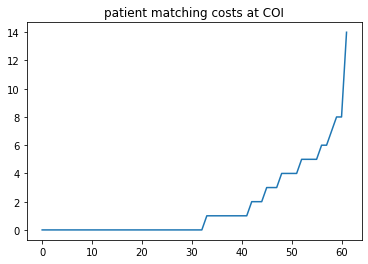

33/62 perfect pairs


In [9]:
matched_pairs, total_cost, sorted_costs = match_sample(healthy_controls_inliers, mdd_patients_inliers)
plt.plot(sorted_costs)
plt.title(f'patient matching costs at COI')
plt.show()
print(f'{np.sum(sorted_costs == 0)}/{min(healthy_controls_inliers.shape[0],mdd_patients_inliers.shape[0])} perfect pairs')

write_pairs(matched_pairs, 'COI')

perfect_pairs = [matched_pair for matched_pair, cost in zip(matched_pairs,sorted_costs) if cost == 0]
write_pairs(perfect_pairs,'COI_perfect')

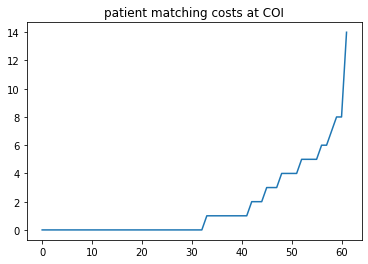

33/62 perfect pairs


In [10]:
matched_pairs, total_cost, sorted_costs = match_sample(healthy_controls_inliers, mdd_patients_inliers)
plt.plot(sorted_costs)
plt.title(f'patient matching costs at COI')
plt.show()
print(f'{np.sum(sorted_costs == 0)}/{min(healthy_controls_inliers.shape[0],mdd_patients_inliers.shape[0])} perfect pairs')

write_pairs(matched_pairs, 'COI')

perfect_pairs = [matched_pair for matched_pair, cost in zip(matched_pairs,sorted_costs) if cost == 0]
write_pairs(perfect_pairs,'COI_perfect')

## Whole dataset

In [11]:
with open('hc_all.txt','r') as f:
    hc_all_ids = json.loads(f.read())
with open('mdd_all.txt','r') as f:
    mdd_all_ids = json.loads(f.read())
with open('all_motion_outliers.txt','r') as f:
    all_motion_outlier_ids = json.loads(f.read())

In [12]:
all_inliers = list(set(hc_all_ids).union(set(mdd_all_ids)) - set(all_motion_outlier_ids))

In [13]:
inliers_data = participants[[participant_id_to_number(name) in all_inliers for name in participants.participant_id.to_numpy()]]

In [14]:
hc_sites = np.unique(inliers_data[inliers_data.diag == 0].site.to_numpy())
mdd_sites = np.unique(inliers_data[inliers_data.diag == 2].site.to_numpy())
sites_in_common = set(hc_sites).intersection(set(mdd_sites))

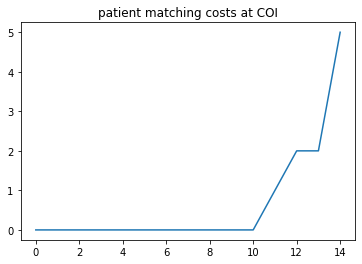

11/15 perfect pairs


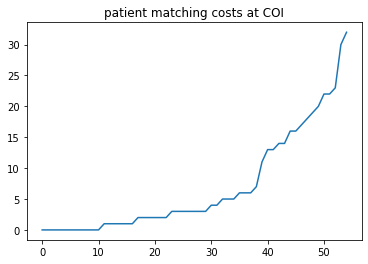

11/55 perfect pairs


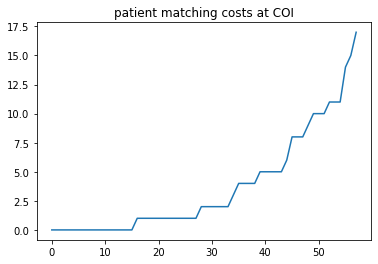

16/58 perfect pairs


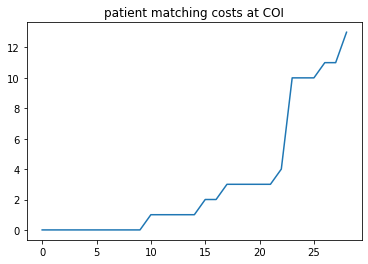

10/29 perfect pairs


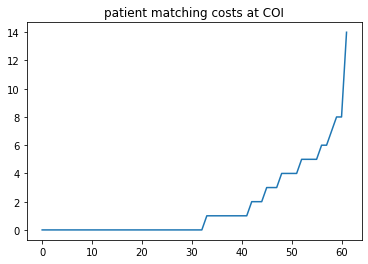

33/62 perfect pairs


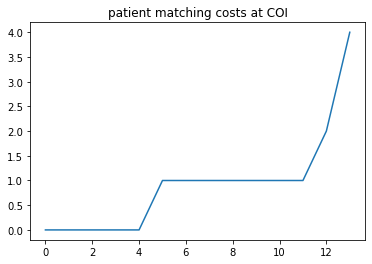

5/14 perfect pairs
Total perfect pairs: 86/233.


In [15]:
total_pairs = []
total_perfect_pairs = []
for site in sites_in_common:
	site_participants = inliers_data[inliers_data.site == site]
	hc = site_participants[site_participants.diag == 0]
	mdd = site_participants[site_participants.diag == 2]

	matched_pairs, total_cost, sorted_costs = match_sample(hc, mdd)
	plt.plot(sorted_costs)
	plt.title(f'patient matching costs at COI')
	plt.show()
	print(f'{np.sum(sorted_costs == 0)}/{min(hc.shape[0],mdd.shape[0])} perfect pairs')

	perfect_pairs = [matched_pair for matched_pair, cost in zip(matched_pairs,sorted_costs) if cost == 0]
	total_pairs += matched_pairs
	total_perfect_pairs += perfect_pairs
print(f'Total perfect pairs: {len(total_perfect_pairs)}/{len(total_pairs)}.')

write_pairs(total_pairs, 'all')
write_pairs(total_perfect_pairs, 'all_perfect')